In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import History

We need only two datasets for this use case: **train.csv** and **store.csv** datasets. <br>Import these datasets after downloading them from www.kaggle.com/c/rossmann-store-sales/data

In [ ]:
train_df = pd.read_csv('train.csv', low_memory=False)
store = pd.read_csv('store.csv')

## Shape of the datasets

In [ ]:
#DISPLAY SHAPE OF THE DATASETS

print ('Shape of train dataset: ', train_df.shape)
print ('Shape of store dataset: ', store.shape)

Shape of train dataset:  (1017209, 9)
Shape of store dataset:  (1115, 10)


In [ ]:
# DISPLAY SOME DATA FROM THE TRAIN DATASET
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
# DISPLAY SOME DATA FROM STORE DATASET
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


As you can see, the train dataset has 1,017,209 rows and 9 columns. In the train dataset, we have data for stores on different days. We have the total sales for the particular day and a couple of additional attributes.
<br>
Likewise, the store dataset has 1115 rows and 10 columns. It gives us additional store attributes that describe store features like assortment type, presence of competition, and promotion-related attributes.

## Get all columns in the train and store datasets

In [ ]:
# ALL COLUMNS IN THE TRAIN  AND STORE DATASET

print (train_df.columns)
print (store.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')
Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


# Merge the two datasets
To have all the data points together, create one single dataframe with the store and promotion features. Display shape of the dataframe

In [ ]:
df_new = train_df.merge(store, on = ['Store'], how='inner')
df_new.shape

(1017209, 18)

# EXPLORATORY DATA ANALYSIS

Now that we have the data in a unified form, We will start by finding the number of unique stores in the data, the number of unique days for which we have data, and the average sales for all stores.


In [ ]:
print("Distinct number of Stores :", len(df_new["Store"].unique()))
print("Distinct number of Days :", len(df_new["Date"].unique()))
print("Average daily sales of all stores : ",round(df_new["Sales"].mean(),2))

Distinct number of Stores : 1115
Distinct number of Days : 942
Average daily sales of all stores :  5773.82


## Find data types

In [ ]:
df_new.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

## Create More features from 'date' feature(column)

### Working with Time

We see a mix of data types here, mostly int and the rest as object or float. <br>
Let’s create additional features that will help our model learn patterns better. We will create the week number, month, day, quarter, and year as features from the date variable. Similarly, since we are already creating time-related features, we can add a new feature based on climate and seasons. Considering that the stores are in Europe, we can refer to the standard season cycles and create a new season feature with values of Spring, Summer, Fall, and Winter.

In [ ]:
# Convert 'date' column to datetime
df_new['Date']  = pd.to_datetime(df_new['Date'], infer_datetime_format=True) 

### Create Month, Year, Day, Week, Qyarter from the 'date' feature

In [ ]:
df_new['Year']  = pd.DatetimeIndex(df_new['Date']).isocalendar().reset_index(drop = True).year
df_new['Month'] = pd.DatetimeIndex(df_new['Date']).month
df_new['Quarter'] = pd.DatetimeIndex(df_new['Date']).quarter
df_new['Week'] = pd.DatetimeIndex(df_new['Date']).isocalendar().reset_index(drop = True).week
df_new['Day'] = pd.DatetimeIndex(df_new['Date']).day

### create a new 'Season' feature for Spring, Summer, Fall, Winter values

In [ ]:
df_new['Season'] = np.where(df_new['Month'].isin([3,4,5]), 'Spring', 
                            np.where(df_new['Month'].isin([6,7,8]), 'Summer', 
                                     np.where(df_new['Month'].isin([9,10,11]), 'Fall', 
                                              np.where(df_new['Month'].isin([12,1,2]), 'Winter', 'None'))))

### View Newly created featured only

In [ ]:
df_new[["Date","Year","Month","Day","Week","Quarter","Season"]].head()

,Date,Year,Month,Day,Week,Quarter,Season
0,2015-07-31,2015,7,31,31,3,Summer
1,2015-07-30,2015,7,30,31,3,Summer
2,2015-07-29,2015,7,29,31,3,Summer
3,2015-07-28,2015,7,28,31,3,Summer
4,2015-07-27,2015,7,27,31,3,Summer


## Predicting Sales

The next feature in the list is the Sales column. This is our **target variable** (i.e., we are developing the model to predict the variable).

### Histogram to study Sales feature

Text(0, 0.5, 'frequency')

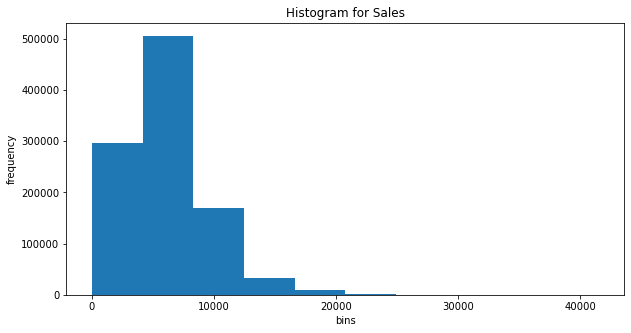

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df_new['Sales'])
plt.title('Histogram for Sales')
plt.xlabel('bins'); plt.ylabel('frequency')

From the preceding plot, we can see that the data range is from 0 to 40,000, but there is barely any data after 20,000. This indicates that most of the stores have sales in the range 0–20,000, and just a few stores have sales greater than 20,000. It might be worthwhile to remove these outliers, as it helps the model learn better.

## Exploring Numerical Colums

visualize a histogram for all numeric
columns within the dataset.

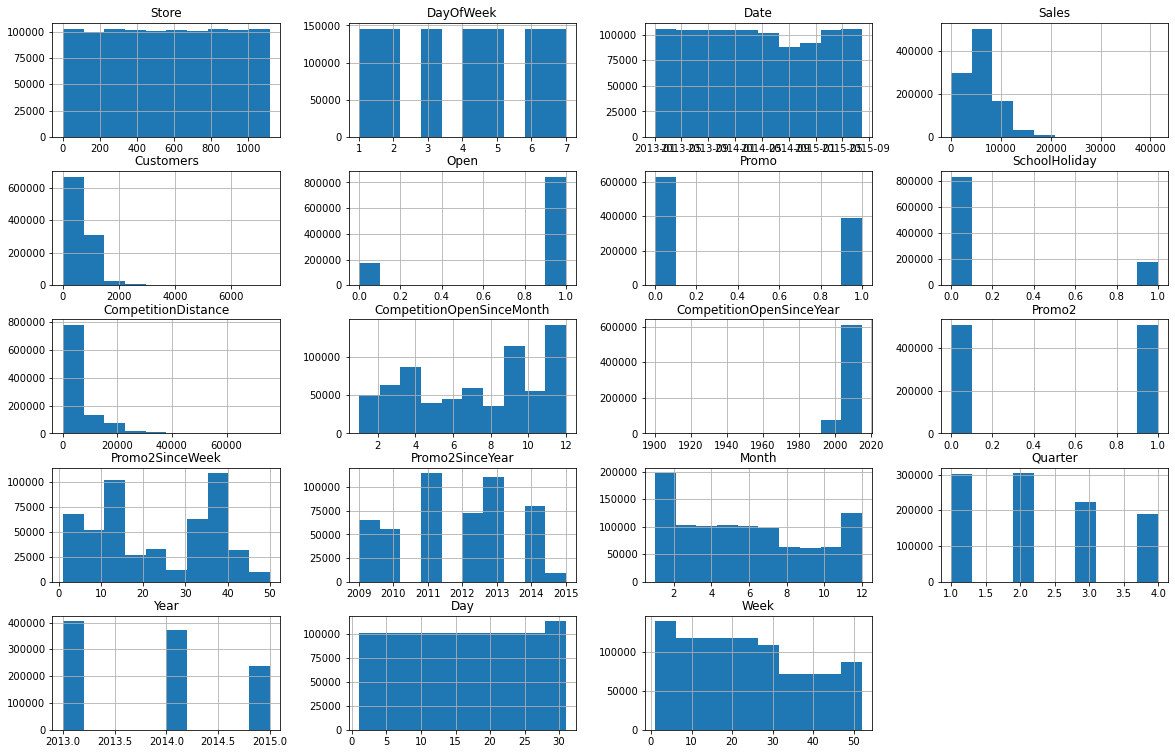

In [ ]:
df_new.hist(figsize=(20,13));

Let’s analyze the results from the histogram showcased in the preceding illustration. We can see that the features Promo, Promo2, SchoolHoliday, and Open are actually binary categorical features: they represent two possible values similar to gender: Male or Female. Therefore, these are actually categorical features but already encoded as numeric columns.This is great; we won’t need to further process them, as DL models understand only numeric values. <br><br>
Promo2 is well distributed between the two distinct values, whereas
Promo has more records for ‘1’ and Open has most of the store records
as ‘1’. The distribution between the values for ‘Open’ makes sense, as the
stores will be open for most days except state holidays. <br><br>
The next set of numeric variables are Promo2SinceWeek and Promo2SinceYear; these show a relatively well-distributed feature. The rest of the histograms are pretty much self-explanatory.



# DATA ENGINEERING

## Data Imputation of  Missing Values

In [ ]:
# PERCENTAGE OF MISSING VALUES
df_new.isnull().sum()/df_new.shape[0] * 100

Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
dtype: float64

We can see that Promo2SinceWeek,
Promo2SinceYear, PromoInterval, CompetitionOpenSinceMonth, and
CompetitionOpenSinceYear have over 30% null values. This is a big
loss and there is nothing much we can do to fix this. As a rule of thumb,
if there is a loss of anything between 0% and 10%, we can make a few
attempts to fill the missing points and use the feature. But, 30% technically
becomes beyond the usable range. On the other hand, we can see
CompetitionDistance has around 0.25% missing values. This would much
easier to handle and fix.

### Impute 'CompetitiveDistance' values with the mode

In [ ]:
df_new['CompetitionDistance'] = df_new['CompetitionDistance'].fillna(df_new['CompetitionDistance'].mode()[0])

## Drop columns with more that 30% missing values

In [ ]:
df_new = df_new.drop([ 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek', 
                      'Promo2SinceYear', 'PromoInterval'], axis=1)

In [ ]:
df_new.dtypes

Store                    int64
DayOfWeek                int64
Sales                    int64
Customers                int64
Open                     int64
Promo                    int64
StateHoliday            object
SchoolHoliday            int64
StoreType               object
Assortment              object
CompetitionDistance    float64
Promo2                   int64
Month                    int64
Quarter                  int64
Year                    UInt32
Day                      int64
Week                    UInt32
Season                  object
dtype: object

## Drop 'Date' Feature and Change 'Year' and 'Week' dtypes to int64

In [ ]:
df_new = df_new.drop(['Date'], axis=1)

In [ ]:
df_new['Year'] = df_new.Year.astype('int64')
df_new['Week'] = df_new.Week.astype('int64')

# Study with  Categorical Features

The best way to study a categorical variable is to study the impact on the target variable from its individual
classes. We can do this by plotting the mean sales across different values of
the classes in the feature.

In [ ]:
# CATEGORICAL COLUMNS
df_new.columns[df_new.dtypes=='O']

Index(['StateHoliday', 'StoreType', 'Assortment', 'Season'], dtype='object')

## Create the bar plot for Average Sales across different Seasons

In [ ]:
sns.set(style='whitegrid')

<AxesSubplot:xlabel='Season', ylabel='Sales'>

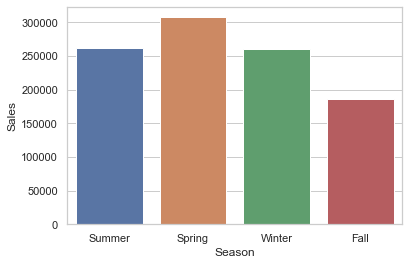

In [ ]:

ax = sns.barplot(x='Season', y='Sales', data=df_new, estimator=np.size)
ax

## #Create the bar plot for Average Sales across different Assortments

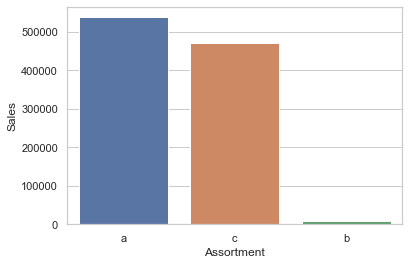

In [ ]:
ax = sns.barplot(x="Assortment", y="Sales", data=df_new,estimator=np.size)

## Create the bar plot for Average Sales across different Store Types

<AxesSubplot:xlabel='StoreType', ylabel='Sales'>

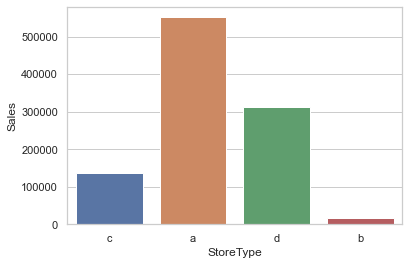

In [ ]:
ax = sns.barplot(x="StoreType", y="Sales", data=df_new, estimator=np.size)
ax

**We can notice that the distribution of data points across different
classes within a category is skewed. A simple check on StoreType and
Assortment reveals that b has a significantly lower number of stores or
data points in the dataset**

### All categorical features stored as text columns need to be converted to a one-hot encoded form for the model training data.


In [ ]:
df_new.dtypes

Store                           int64
DayOfWeek                       int64
Date                   datetime64[ns]
Sales                           int64
Customers                       int64
Open                            int64
Promo                           int64
StateHoliday                   object
SchoolHoliday                   int64
StoreType                      object
Assortment                     object
CompetitionDistance           float64
Promo2                          int64
Month                           int64
Quarter                         int64
Year                           UInt32
Day                             int64
Week                           UInt32
Season                         object
dtype: object

In [ ]:
df_new.columns[df_new.dtypes=='int64']

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Promo2', 'Month', 'Quarter', 'Day'],
      dtype='object')

In [ ]:
df_new.columns[df_new.dtypes=='float']

Index(['CompetitionDistance'], dtype='object')

In [ ]:
df_new.columns[df_new.dtypes=='O']

Index(['StateHoliday', 'StoreType', 'Assortment', 'Season'], dtype='object')

##  Convert 'StateHoliday' Feature to numerical

In [ ]:
df_new.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [ ]:
df_new['StateHoliday'] = np.where(df_new['StateHoliday'] == '0', 0, 1)

In [ ]:
df_new.StateHoliday = df_new.StateHoliday.astype('int64')

In [ ]:
df_new.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [ ]:
num_columns =set(df_new.columns[df_new.dtypes=='int64']).union(set(df_new.columns[df_new.dtypes=='float64']))

In [ ]:
cat_columns = df_new.columns[df_new.dtypes=='O'] 

## Label and One Hot Encode Categorical Features

In [ ]:
numerical_columns = num_columns
categorical_columns = cat_columns

In [ ]:
num_df = df_new[numerical_columns]

In [ ]:
# Function that returns a dataframe with one hot encoded features

def create_ohe (df, col):
    le = LabelEncoder()
    a = le.fit_transform(df_new[col]).reshape(-1,1)
    ohe = OneHotEncoder(sparse=False)
    column_names  = [col+ "_"+ str(i) for i in le.classes_]
    return(pd.DataFrame(ohe.fit_transform(a),columns =column_names))

In [ ]:
#Create a list of dataframes created by the function above for each categorical column

cat_df  = [create_ohe(df_new, col) for col in categorical_columns]

In [ ]:
# concatenate the dataframes in the list into one dataframe
cat_df  = pd.concat(cat_df, axis=1)

In [ ]:
# Finally, concatenate the num_df and cat_df together to make a final dataframe
final_df = pd.concat([num_df, cat_df], axis=1)

In [ ]:
df_new.shape

(1017209, 18)

In [ ]:
final_df.shape

(1017209, 26)

In [ ]:
final_df.head()

,Promo2,Customers,CompetitionDistance,Week,Sales,Year,DayOfWeek,StateHoliday,Quarter,Month,...,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Season_Fall,Season_Spring,Season_Summer,Season_Winter
0,0,555,1270.0,31,5263,2015,5,0,3,7,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,546,1270.0,31,5020,2015,4,0,3,7,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,523,1270.0,31,4782,2015,3,0,3,7,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,560,1270.0,31,5011,2015,2,0,3,7,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,612,1270.0,31,6102,2015,1,0,3,7,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
target  = final_df.Sales

In [ ]:
final_df = final_df.drop(['Sales'], axis=1)

# Train_Test Split the final_df

## train and test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_df, target,test_size=0.2,random_state=2021)

## train and validation data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.1,random_state=2021)

# DEFINE MODEL BASELINE PERFORMANCE

To define the model baseline performance, we should consider the mean
of the target variable in the training dataset as the prediction for all test
samples. The metric we shall use to perform this test is MAE (mean
absolute error).

In [ ]:
#calculate the average score of the train datase
average_sales = df_new.Sales.mean()
average_sales

5773.818972305593

Now, if we assume the average sales as the prediction for all samples in 
the test dataset, what does the MAE metric look like?




In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
#Calculate the Mean Absolute Error on the test dataset
print("MAE for Test Data:",abs(y_test-average_sales).mean())

MAE for Test Data: 2890.2419927938413


So, our baseline performance is  **2890.24**.
If our DL model doesn’t deliver results better (i.e., lower) than the
baseline score, then it would barely add any value.

# DESIGNING THE DNN

Additionally, we add a new optional configuration to the
model to record the history of various metrics during the training process. This can be done by adding the callbacks parameter. We can use the history, post training, to visualize and
understand the model’s learning curve.

In [ ]:
history = History()
model = Sequential()

model.add(Dense(350,input_dim = 25,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(1,activation = "linear"))
model.compile(optimizer='adam',loss="mean_squared_error",metrics=["mean_absolute_error"])
model.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=10,batch_size=64,callbacks=[history]) 

# MODEL PERFORMANCE
result = model.evaluate(X_test,y_test)

for i in range(len(model.metrics_names)):
     print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

Epoch 1/10
11444/11444 [==============================] - 71s 6ms/step - loss: 1611820.1250 - mean_absolute_error: 835.2662 - val_loss: 1368124.1250 - val_mean_absolute_error: 799.0347
Epoch 2/10
11444/11444 [==============================] - 68s 6ms/step - loss: 1136262.8750 - mean_absolute_error: 717.8991 - val_loss: 1117579.2500 - val_mean_absolute_error: 705.6403
Epoch 3/10
11444/11444 [==============================] - 70s 6ms/step - loss: 1066078.6250 - mean_absolute_error: 695.7086 - val_loss: 1196500.7500 - val_mean_absolute_error: 753.4298
Epoch 4/10
11444/11444 [==============================] - 68s 6ms/step - loss: 1011957.3125 - mean_absolute_error: 677.6421 - val_loss: 986843.6875 - val_mean_absolute_error: 681.4932
Epoch 5/10
11444/11444 [==============================] - 69s 6ms/step - loss: 955757.8125 - mean_absolute_error: 657.7277 - val_loss: 993192.8750 - val_mean_absolute_error: 671.5330
Epoch 6/10
11444/11444 [==============================] - 69s 6ms/step - loss:

**we can see a positive performance. The model
performance on the validation dataset was 577.75, which is way better than
our baseline score. The Model performance on the test data is 555.84, which a relatively consistent performance** 

 # Plotting the Loss Metric Across Epochs
The model also stores the history of a few important parameters and
metrics we configured for the model. To see what the model training
process looked like, we can plot the loss metric across epochs and see the 
amount of reduction the model achieved with each epoch.

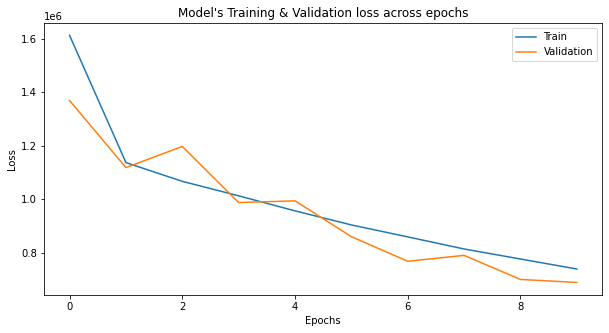

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

We can see that after a point the net decrease in loss was quite low but
still relatively good. We could probably increase the number of epochs
to test whether model performance is improving further. Of course, this
comes with a significant amount of computation time for training, but
once you have finalized the architecture for your model, you can increase
the number of epochs for training and check if there was any further
improvement.